In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.stats import kendalltau
from scipy.linalg import toeplitz, hankel
from scipy.signal import stft
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

In [5]:
## DO NOT RUN THIS IS A LONG BOY ##
rdr = pd.read_csv("paxraw.csv.gz", error_bad_lines=False, chunksize=24*60*7)

# If true, use Kandall's-tau, else use standard autocorrelation.
# Calculating the tau correlations for all data takes several
# hours, standard autocorrelations are much faster.
tau = False

# Number of autocorrelation lags to compute
nlags = 60*24

results = []

def process(df):

    if tau:
        x = df.PAXINTEN
        a = np.zeros(nlags+1)
        a[0] = 1
        for l in range(1, nlags+1):
            a[l] = kendalltau(x[0:-l], x[l:]).correlation
    else:
        a = acf(df.PAXINTEN, nlags=nlags, fft=True)

    if np.isnan(a).any():
        eiv = np.nan*np.ones(len(a))
    else:
        c = toeplitz(a)
        eiv, eig = np.linalg.eigh(c)
        ii = np.argsort(-eiv)
        eiv = eiv[ii]
        eig = eig[:, ii]

    eiv = np.concatenate(([df.SEQN.iloc[0]], eiv))
    results.append(eiv)


chunks = []
nsubject = 0
while True:

    try:
        df1 = rdr.get_chunk()
    except StopIteration:
        break

    for idx, v in df1.groupby("SEQN"):
        chunks.append((idx, v))

    ids = [x[0] for x in chunks]

    if len(set(ids)) > 1:
        # z contains complete data for one subject and is
        # ready to process
        z = [x[1] for x in chunks if x[0] == ids[0]]
        chunks = [x for x in chunks if x[0] != ids[0]]
    else:
        continue

    z = pd.concat(z, axis=0)
    process(z)

    nsubject += 1
    if nsubject % 10 == 0:
        print(nsubject)

results = pd.DataFrame.from_records(results)
results.columns = ["SEQN"] + ["eig%03d" % k for k in range(nlags+1)]
results["SEQN"] = results["SEQN"].astype(np.int)
if tau:
    results.to_csv("ssa_eig_tau.csv.gz", index=None)
else:
    results.to_csv("ssa_eig.csv.gz", index=None)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740


c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:578: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790


In [6]:
## DO NOT RUN THIS IS BASICALLY USELESS ##

"""
Merge actigraphy data with other NHANES data.
The actigraphy data are from the 2003-2004 wave of NHANES.
Below are some of the other NHANES files from the same wave that
we can merge with the actigraphy data, using the SEQN
subject identifier.
https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/DEMO_C.XPT
https://wwwn.cdc.gov/Nchs/Nhanes/2003-2004/BPX_C.XPT
"""

# Actigraphy data
act = pd.read_csv("ssa_eig.csv.gz")

# Demographic data
demo = pd.read_sas("DEMO_C.XPT")
demo = demo[["SEQN", "RIDAGEYR", "RIAGENDR"]]

# Blood pressure data
bp = pd.read_sas("BPX_C.XPT")
bp = bp[["SEQN", "BPXSY1", "BPXSY2"]]

df = pd.merge(demo, act, left_on="SEQN", right_on="SEQN")
df = pd.merge(df, bp, left_on="SEQN", right_on="SEQN")

df.to_csv("nhanes_merged.csv.gz", index=None)

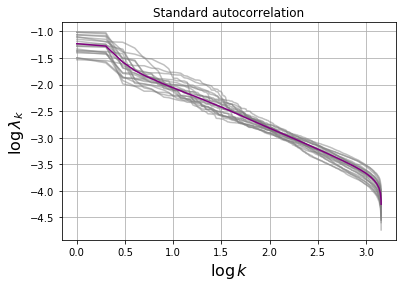

In [47]:
## THIS GAVE US THE OG SSA GRAPHS ##
pdf = PdfPages("ssa_graphs.pdf")

eiv = pd.read_csv("ssa_eig.csv.gz")
eiv = eiv.set_index("SEQN")

# Normalize
eivn = eiv.div(eiv.sum(1), axis=0)

plt.clf()
plt.grid(True)
lk = np.log10(1 + np.arange(eivn.shape[1]))
for i in range(20):
    plt.plot(lk, np.log10(eivn.iloc[i, :]), color='grey', alpha=0.5)
y = eivn.mean(0)
plt.plot(lk, np.log10(y), color='purple')
plt.xlabel(r"$\log\, k$", size=16)
plt.ylabel(r"$\log\, \lambda_k$", size=16)
plt.title("Standard autocorrelation")
pdf.savefig()
pdf.close()

RIGHT HERE YOU MOFO

c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\luxa

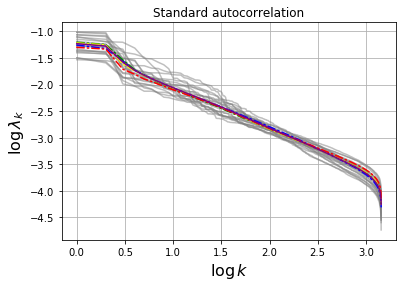

In [28]:
## CURRENTLY WORKING ON THIS HAVING DIFF CATEGORIES ##

pdf = PdfPages("ssa_age.pdf")

eiv = pd.read_csv("ssa_eig.csv.gz")

eiv = eiv.set_index("SEQN")

# Normalize
eivn = eiv.div(eiv.sum(1), axis=0)


# Demographic data
demo = pd.read_sas("DEMO_C.XPT")
demo = demo[["SEQN", "RIDAGEYR"]]

df = pd.merge(demo, eivn, left_on="SEQN", right_on="SEQN")
df['age'] = 0
df.age[(df.RIDAGEYR >= 16) & (df.RIDAGEYR < 25)] = 1
df.age[(df.RIDAGEYR >= 25) & (df.RIDAGEYR < 51)] = 2
df.age[(df.RIDAGEYR >= 51) & (df.RIDAGEYR < 66)] = 3
df.age[df.RIDAGEYR >= 66] = 4
df = df.set_index("SEQN")

plt.clf()
plt.grid(True)
lk = np.log10(1 + np.arange(eivn.shape[1]))
for i in range(20):
    plt.plot(lk, np.log10(eivn.iloc[i, :]), color='grey', alpha=0.5)

eiv_1 = df[df.age == 1]
del eiv_1['RIDAGEYR']
del eiv_1['age']
age_1 = eiv_1.mean(0)
plt.plot(lk, np.log10(age_1), color='blue', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_2 = df[df.age == 2]
del eiv_2['RIDAGEYR']
del eiv_2['age']
age_2 = eiv_2.mean(0)
plt.plot(lk, np.log10(age_2), color='green', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_3 = df[df.age == 3]
del eiv_3['RIDAGEYR']
del eiv_3['age']
age_3 = eiv_3.mean(0)
plt.plot(lk, np.log10(age_3), color='yellow', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_4 = df[df.age == 4]
del eiv_4['RIDAGEYR']
del eiv_4['age']
age_4 = eiv_4.mean(0)
plt.plot(lk, np.log10(age_4), color='red', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

y = eivn.mean(0)
plt.plot(lk, np.log10(y), color='purple')

plt.xlabel(r"$\log\, k$", size=16)
plt.ylabel(r"$\log\, \lambda_k$", size=16)
plt.title("Standard autocorrelation")
pdf.savefig()
pdf.close()

c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


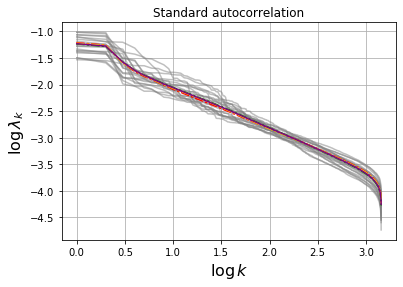

In [10]:
## CURRENTLY WORKING ON THIS HAVING DIFF CATEGORIES ##

pdf = PdfPages("ssa_chol.pdf")

eiv = pd.read_csv("ssa_eig.csv.gz")

eiv = eiv.set_index("SEQN")

# Normalize
eivn = eiv.div(eiv.sum(1), axis=0)


# Demographic data
new = pd.read_sas("L13_C.XPT")
new = new[["SEQN", "LBXTC"]]

df = pd.merge(new, eivn, left_on="SEQN", right_on="SEQN")
df['chol'] = 0
df.chol[(df.LBXTC < 200)] = 1
df.chol[(df.LBXTC >= 200) & (df.LBXTC < 240)] = 2
df.chol[df.LBXTC >= 240] = 3
del df['LBXTC']
df = df.set_index("SEQN")

plt.clf()
plt.grid(True)
lk = np.log10(1 + np.arange(eivn.shape[1]))
for i in range(20):
    plt.plot(lk, np.log10(eivn.iloc[i, :]), color='grey', alpha=0.5)

eiv_3 = df[df.chol == 3]
del eiv_3['chol']
chol_3 = eiv_3.mean(0)
plt.plot(lk, np.log10(chol_3), color='red', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    
eiv_1 = df[df.chol == 1]
del eiv_1['chol']
chol_1 = eiv_1.mean(0)
plt.plot(lk, np.log10(chol_1), color='green', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_2 = df[df.chol == 2]
del eiv_2['chol']
chol_2 = eiv_2.mean(0)
plt.plot(lk, np.log10(chol_2), color='yellow', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

y = eivn.mean(0)
plt.plot(lk, np.log10(y), color='purple')

plt.xlabel(r"$\log\, k$", size=16)
plt.ylabel(r"$\log\, \lambda_k$", size=16)
plt.title("Standard autocorrelation")
pdf.savefig()
pdf.close()

In [ ]:
## CURRENTLY WORKING ON THIS HAVING DIFF CATEGORIES ##

pdf = PdfPages("ssa_bp.pdf")

eiv = pd.read_csv("ssa_eig.csv.gz")

eiv = eiv.set_index("SEQN")

# Normalize
eivn = eiv.div(eiv.sum(1), axis=0)


# Demographic data
bp = pd.read_sas("BPX_C.XPT")
bp = bp[["SEQN", "BPXSY1", "BPXSY2"]]

df = pd.merge(bp, eivn, left_on="SEQN", right_on="SEQN")
df['avg_bp'] = (df.BPXSY1 + df.BPXSY2)/2
df['bp'] = 0
df.bp[(df.avg_bp < 120)] = 1
df.bp[(df.avg_bp >= 120) & (df.avg_bp < 130 )] = 2
df.bp[(df.avg_bp >= 130) & (df.avg_bp < 140 )] = 3
df.bp[df.avg_bp >= 140] = 4
del df['BPXSY1']
del df['BPXSY2']
del df['avg_bp']
df = df.set_index("SEQN")

plt.clf()
plt.grid(True)
lk = np.log10(1 + np.arange(eivn.shape[1]))
for i in range(20):
    plt.plot(lk, np.log10(eivn.iloc[i, :]), color='grey', alpha=0.5)
    
eiv_1 = df[df.bp == 1]
del eiv_1['bp']
bp_1 = eiv_1.mean(0)
plt.plot(lk, np.log10(bp_1), color='blue', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_2 = df[df.bp == 2]
del eiv_2['bp']
bp_2 = eiv_2.mean(0)
plt.plot(lk, np.log10(bp_2), color='green', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_3 = df[df.bp == 3]
del eiv_3['bp']
bp_3 = eiv_3.mean(0)
plt.plot(lk, np.log10(bp_3), color='yellow', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_4 = df[df.bp == 4]
del eiv_4['bp']
bp_4 = eiv_4.mean(0)
plt.plot(lk, np.log10(bp_4), color='red', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

y = eivn.mean(0)
plt.plot(lk, np.log10(y), color='purple')

plt.xlabel(r"$\log\, k$", size=16)
plt.ylabel(r"$\log\, \lambda_k$", size=16)
plt.title("Standard autocorrelation")
pdf.savefig()
pdf.close()

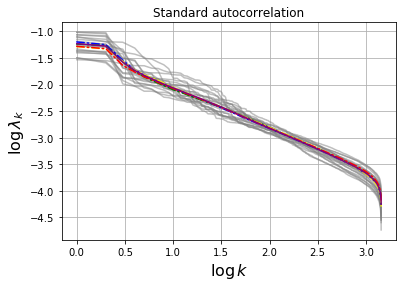

In [6]:
## CURRENTLY WORKING ON THIS HAVING DIFF CATEGORIES ##

pdf = PdfPages("ssa_job.pdf")

eiv = pd.read_csv("ssa_eig.csv.gz")

eiv = eiv.set_index("SEQN")

# Normalize
eivn = eiv.div(eiv.sum(1), axis=0)


# Demographic data
jb = pd.read_sas("OCQ_C.XPT")
jb = jb[["SEQN", "OCD150"]]

df = pd.merge(jb, eivn, left_on="SEQN", right_on="SEQN")
df = df.set_index("SEQN")

plt.clf()
plt.grid(True)
lk = np.log10(1 + np.arange(eivn.shape[1]))
for i in range(20):
    plt.plot(lk, np.log10(eivn.iloc[i, :]), color='grey', alpha=0.5)
    
eiv_1 = df[df.OCD150 == 1]
del eiv_1['OCD150']
jb_1 = eiv_1.mean(0)
plt.plot(lk, np.log10(jb_1), color='blue', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_2 = df[df.OCD150 == 2]
del eiv_2['OCD150']
jb_2 = eiv_2.mean(0)
plt.plot(lk, np.log10(jb_2), color='green', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_3 = df[df.OCD150 == 3]
del eiv_3['OCD150']
jb_3 = eiv_3.mean(0)
plt.plot(lk, np.log10(jb_3), color='yellow', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_4 = df[df.OCD150 == 4]
del eiv_4['OCD150']
jb_4 = eiv_4.mean(0)
plt.plot(lk, np.log10(jb_4), color='red', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

y = eivn.mean(0)
plt.plot(lk, np.log10(y), color='purple')

plt.xlabel(r"$\log\, k$", size=16)
plt.ylabel(r"$\log\, \lambda_k$", size=16)
plt.title("Standard autocorrelation")
pdf.savefig()
pdf.close()

c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\luxa

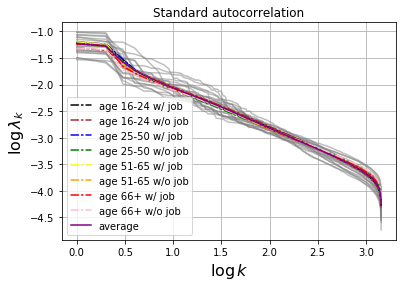

In [9]:
# THE COLLAB
pdf = PdfPages("ssa_agejob.pdf")

eiv = pd.read_csv("ssa_eig.csv.gz")

eiv = eiv.set_index("SEQN")

# Normalize
eivn = eiv.div(eiv.sum(1), axis=0)


# Demographic data
demo = pd.read_sas("DEMO_C.XPT")
demo = demo[["SEQN", "RIDAGEYR"]]

jb = pd.read_sas("OCQ_C.XPT")
jb = jb[["SEQN", "OCD150"]]

df = pd.merge(demo, eivn, left_on="SEQN", right_on="SEQN")
df = pd.merge(jb, df, left_on="SEQN", right_on="SEQN")

df['age'] = 0
df.age[(df.RIDAGEYR <= 24)] = 1
df.age[(df.RIDAGEYR > 24) & (df.RIDAGEYR <= 50)] = 2
df.age[(df.RIDAGEYR > 50) & (df.RIDAGEYR <= 65)] = 3
df.age[df.RIDAGEYR > 65] = 4

df['job'] = 0
df.job[(df.OCD150 == 1) | (df.OCD150 == 2)] = 1
df.job[(df.OCD150 == 3) | (df.OCD150 == 4)] = 2

df['agejob'] = 0
df.agejob[(df.age == 1) & (df.job == 1)] = 1
df.agejob[(df.age == 1) & (df.job == 2)] = 2
df.agejob[(df.age == 2) & (df.job == 1)] = 3
df.agejob[(df.age == 2) & (df.job == 2)] = 4
df.agejob[(df.age == 3) & (df.job == 1)] = 5
df.agejob[(df.age == 3) & (df.job == 2)] = 6
df.agejob[(df.age == 4) & (df.job == 1)] = 7
df.agejob[(df.age == 4) & (df.job == 2)] = 8

del df['RIDAGEYR']
del df['OCD150']
del df['age']
del df['job']

df = df.set_index("SEQN")

plt.clf()
plt.grid(True)
lk = np.log10(1 + np.arange(eivn.shape[1]))
for i in range(20):
    plt.plot(lk, np.log10(eivn.iloc[i, :]), color='grey', alpha=0.5)

eiv_1 = df[df.agejob == 1]
del eiv_1['agejob']
agejob_1 = eiv_1.mean(0)
plt.plot(lk, np.log10(agejob_1), label='age 16-24 w/ job', color='black', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_2 = df[df.agejob == 2]
del eiv_2['agejob']
agejob_2 = eiv_2.mean(0)
plt.plot(lk, np.log10(agejob_2), label='age 16-24 w/o job', color='brown', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_3 = df[df.agejob == 3]
del eiv_3['agejob']
agejob_3 = eiv_3.mean(0)
plt.plot(lk, np.log10(agejob_3), label='age 25-50 w/ job', color='blue', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_4 = df[df.agejob == 4]
del eiv_4['agejob']
agejob_4 = eiv_4.mean(0)
plt.plot(lk, np.log10(agejob_4), label='age 25-50 w/o job', color='green', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_5 = df[df.agejob == 5]
del eiv_5['agejob']
agejob_5 = eiv_5.mean(0)
plt.plot(lk, np.log10(agejob_5), label='age 51-65 w/ job', color='yellow', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_6 = df[df.agejob == 6]
del eiv_6['agejob']
agejob_6 = eiv_6.mean(0)
plt.plot(lk, np.log10(agejob_6), label='age 51-65 w/o job', color='orange', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_7 = df[df.agejob == 7]
del eiv_7['agejob']
agejob_7 = eiv_7.mean(0)
plt.plot(lk, np.log10(agejob_7), label='age 66+ w/ job', color='red', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

eiv_8 = df[df.agejob == 8]
del eiv_8['agejob']
agejob_8 = eiv_8.mean(0)
plt.plot(lk, np.log10(agejob_8), label='age 66+ w/o job', color='pink', linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')

y = eivn.mean(0)
plt.plot(lk, np.log10(y), label='average', color='purple')

plt.xlabel(r"$\log\, k$", size=16)
plt.ylabel(r"$\log\, \lambda_k$", size=16)
plt.legend()
plt.title("Standard autocorrelation")
pdf.savefig()
pdf.close()

(array([1421., 1669.,  602.,  575.,  552.,  523.,  454.,  493.,  437.,
         441.]),
 array([ 6. , 13.9, 21.8, 29.7, 37.6, 45.5, 53.4, 61.3, 69.2, 77.1, 85. ]),
 <a list of 10 Patch objects>)

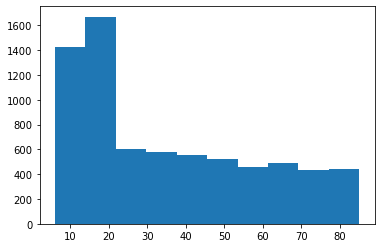

In [5]:
eiv = pd.read_csv("ssa_eig.csv.gz")

eiv = eiv.set_index("SEQN")

# Normalize
eivn = eiv.div(eiv.sum(1), axis=0)


# Demographic data
demo = pd.read_sas("DEMO_C.XPT")
demo = demo[["SEQN", "RIDAGEYR"]]

df = pd.merge(demo, eivn, left_on="SEQN", right_on="SEQN")
plt.hist(df.RIDAGEYR)

In [7]:
df.RIDAGEYR.max()

85.0

10
20
30


UnboundLocalError: local variable 'eig' referenced before assignment

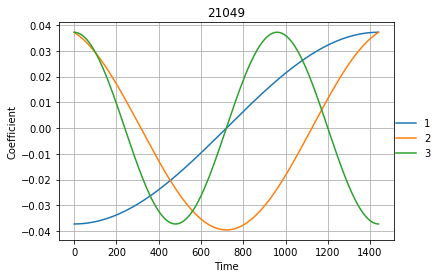

In [92]:
## FOR YOUR SQUIGGLY COMPONENT GRAPHS ##

rdr = pd.read_csv("paxraw.csv.gz", error_bad_lines=False, chunksize=24*60*7)

# Number of autocorrelation lags to compute
nlags = 60*24

pdf = PdfPages("ssa_components.pdf")

results = []

def process(df, tau):

    if tau:
        x = df.PAXINTEN
        a = np.zeros(nlags+1)
        a[0] = 1
        for l in range(1, nlags+1):
            a[l] = kendalltau(x[0:-l], x[l:]).correlation
    else:
        a = acf(df.PAXINTEN, nlags=nlags, fft=True)

    if np.isnan(a).any():
        eiv = np.nan*np.ones(len(a))
    else:
        c = toeplitz(a)
        eiv, eig = np.linalg.eigh(c)
        ii = np.argsort(-eiv)
        eiv = eiv[ii]
        eig = eig[:, ii]

    y = df.PAXINTEN.values
    y = y - y.mean()

    # Get the component corresponding to each
    # singular value.
    xm = hankel(y)[:, 0:nlags+1]
    s = np.sqrt(eiv)
    u = np.dot(xm, eig) / s

    if not tau:
        plt.clf()
        plt.grid(True)
        plt.plot(y)
        plt.xlabel("Time")
        plt.ylabel("Intensity")
        plt.title(df.SEQN.iloc[0])
        pdf.savefig()

    # Plot the components
    plt.clf()
    plt.grid(True)
    for j in 0, 1, 2:
        plt.plot(u[:, j], label=str(j+1))
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)
    if tau:
        plt.title(str(df.SEQN.iloc[0]) + " (tau)")
    else:
        plt.title(df.SEQN.iloc[0])
    plt.xlabel("Time")
    plt.ylabel("Loading")
    pdf.savefig()

    # Plot the coefficients
    plt.clf()
    plt.grid(True)
    for j in 0, 1, 2:
        plt.plot(eig[:, j], label=str(j+1))
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)
    if tau:
        plt.title(str(df.SEQN.iloc[0]) + " (tau)")
    else:
        plt.title(df.SEQN.iloc[0])
    plt.xlabel("Time")
    plt.ylabel("Coefficient")
    pdf.savefig()

    eiv = np.concatenate(([df.SEQN.iloc[0]], eiv))
    results.append(eiv)


chunks = []
nsubject = 0
while True:

    try:
        df1 = rdr.get_chunk()
    except StopIteration:
        break

    for idx, v in df1.groupby("SEQN"):
        chunks.append((idx, v))

    ids = [x[0] for x in chunks]

    if len(set(ids)) > 1:
        # z contains complete data for one subject and is
        # ready to process
        z = [x[1] for x in chunks if x[0] == ids[0]]
        chunks = [x for x in chunks if x[0] != ids[0]]
    else:
        continue

    z = pd.concat(z, axis=0)

    for tau in False, True:
        process(z, tau)

    nsubject += 1
    if nsubject % 10 == 0:
        print(nsubject)

    if nsubject > 50:
        break

pdf.close()

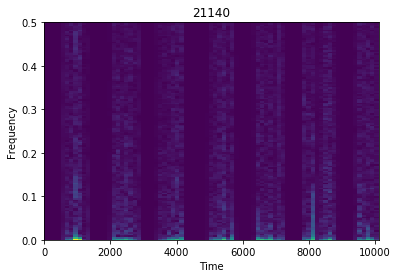

In [38]:
## FOR TFR FUN HOT MAP GRAPHS ##

rdr = pd.read_csv("paxraw.csv.gz", error_bad_lines=False, chunksize=24*60*7)

pdf = PdfPages("tfr.pdf")

def process_2(y, name):
    w = stft(y, nperseg=60*24)

    plt.clf()
    plt.grid(True)
    plt.plot(y)
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.title(str(name))
    pdf.savefig()

    plt.clf()
    f, t, zxx = stft(y)
    plt.pcolormesh(t, f, np.abs(zxx), vmin=0)
    plt.ylabel("Frequency")
    plt.xlabel("Time")
    plt.title(str(name))
    pdf.savefig()

# Make TFR plots for a few of the actual time series.

chunks = []
nsubject = 0
while True:

    try:
        df1 = rdr.get_chunk()
    except StopIteration:
        break

    for idx, v in df1.groupby("SEQN"):
        chunks.append((idx, v))

    ids = [x[0] for x in chunks]

    if len(set(ids)) > 1:
        # z contains complete data for one subject and is
        # ready to process
        z = [x[1] for x in chunks if x[0] == ids[0]]
        chunks = [x for x in chunks if x[0] != ids[0]]
    else:
        continue

    z = pd.concat(z, axis=0)
    process_2(z.PAXINTEN, z.SEQN.iloc[0])

    nsubject += 1
    if nsubject > 100:
        break

pdf.close()